<a href="https://colab.research.google.com/github/CGPiguet/nnPU-MNIST-Experiment-Pytorch/blob/main/nnPU_experiment_from_chainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

10.06.2021 : Most recent version, closest to chainer Implementation

> Characteristics

*   lr = 0.001
*   Dataset function from chainer experiments/Kyrio (no transforms)
*   3 Dataloader (train, valid(=train in chainer, validtrain here), test(=valid)
*   Dataloader(train_dataset, ..., drop_last= True) to simulate chainer
*   Unlabeled = 60000, labeled = 1000, train_dataset= 61000, test_dataset= 10000
*   Same evaluation metrics as in chainer






# Initialisation

In [ ]:
# ##Google Collab
# #Drive mountr 
# from google.colab import drive
# from google.colab import output
# drive.mount('/content/drive/', force_remount= False)

In [ ]:
import sys
sys.path.append('//content/drive/My Drive/Colab Notebooks/MasterThesis')

In [ ]:
import os 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision

from tqdm.notebook import tqdm, trange
from torchsummary import summary

import numpy as np
# For ROC metrics
from sklearn import metrics

from IPython.display import clear_output 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

In [ ]:
SEED = 0
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print(device)

cuda


In [ ]:
# To bypass CloudFlare Protection of the MNIST dataset
from six.moves import urllib    
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# Dataset

## Pytorch

In [ ]:
#From https://github.com/cimeister/pu-learning
download =  True

from torchvision.datasets import MNIST, CIFAR10
class PU_MNIST(MNIST):
  def __init__(self, root, train= True, transform= None, target_transform= None, download= False):
    super(PU_MNIST, self).__init__(root, train=train, transform= transform, target_transform= target_transform, download= download)
    self.pos_indices = []
    i = 0

    
    # Save the first 1000 data as P (positive) class
    while len(self.pos_indices) < 1000:
      if self.targets[i] % 2 == 0:
        self.pos_indices.append(i)
      i += 1

  def __getitem__(self, i):
    input, target = super(PU_MNIST, self).__getitem__(i)
    # Retrieve 1 if i belong to the P class or -1 if not
    # input = np.array(input)/255
    # input = torch.tensor(input, dtype= torch.float32)
    if i in self.pos_indices:
      target = torch.tensor(1)
    else:
      target = torch.tensor(-1)
    return input, target 

  def get_prior(self):
    # I assumed it is symbolise in the paper by pi_p = p(Y = +1)
    pos_example = self.targets % 2 == 0
    return torch.sum(pos_example, dtype=torch.float) / len(self.targets)



class PN_MNIST(MNIST):
  ## We add this 
  def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
    super(PN_MNIST, self).__init__(root, train=train, transform=transform, target_transform=target_transform, download=download)
  ##
  def __getitem__(self, i):
    input, target = super(PN_MNIST, self).__getitem__(i)
    # input = np.array(input)/255
    # input = torch.tensor(input, dtype= torch.float32)
    # Retrieve -1 for N class and 1 for P class 
    if target % 2 == 0:
      target = torch.tensor(1)
    else:
      target = torch.tensor(-1)

    return input, target 

In [ ]:
from torchvision.transforms import ToTensor, Normalize, Compose
transforms = Compose([
    ToTensor(),
    Normalize(mean=(0.5,), std=(0.5,))
])

# It seems that in the original paper, they didnt' implent any normalization excepti a divive by 255 to make the value in the range of [0,1]

In [ ]:
# dataset = {'train': PU_MNIST(root='/content/', train= True, download= download,transform= None),
#            'valid': PN_MNIST(root='/content/', train= False, download= download,transform= None)}           
# batch_size =   30000
# dataloader = {'train': DataLoader(dataset['train'], batch_size= batch_size, shuffle= True, drop_last= True, **kwargs),
#               'validtrain': DataLoader(dataset['train'], batch_size= batch_size, shuffle= False, **kwargs),
#               'valid': DataLoader(dataset['valid'], batch_size= batch_size, shuffle= False, **kwargs)}
# clear_output()

In [ ]:
# input, target = dataset['train'][0]
# plt.hist(input.squeeze().numpy())
# prior = dataset['train'].get_prior()

## Chainer


In [ ]:
import numpy as np
import urllib.request
import os
import tarfile
import pickle
from sklearn.datasets import fetch_openml

def get_mnist():
    mnist = fetch_openml('mnist_784', data_home=".")

    x = mnist.data
    y = mnist.target
    # reshape to (#data, #channel, width, height)
    x = np.reshape(x, (x.shape[0], 1, 28, 28)) / 255.
    x_tr = np.asarray(x[:60000], dtype=np.float32)
    y_tr = np.asarray(y[:60000], dtype=np.int32)
    x_te = np.asarray(x[60000:], dtype=np.float32)
    y_te = np.asarray(y[60000:], dtype=np.int32)
    return (x_tr, y_tr), (x_te, y_te)


def binarize_mnist_class(y_train, y_test):
    y_train_bin = np.ones(len(y_train), dtype=np.int32)
    y_train_bin[y_train % 2 == 1] = -1
    y_test_bin = np.ones(len(y_test), dtype=np.int32)
    y_test_bin[y_test % 2 == 1] = -1
    return y_train_bin, y_test_bin


def unpickle(file):
    fo = open(file, 'rb')
    dictionary = pickle.load(fo, encoding='latin1')
    fo.close()
    return dictionary


def conv_data2image(data):
    return np.rollaxis(data.reshape((3, 32, 32)), 0, 3)


def make_dataset(dataset, n_labeled, n_unlabeled):
    def make_pu_dataset_from_binary_dataset(x, y, labeled=n_labeled, unlabeled=n_unlabeled):
        labels = np.unique(y)
        positive, negative = labels[1], labels[0]
        x, y = np.asarray(x, dtype=np.float32), np.asarray(y, dtype=np.int32)
        # print('x: {}\ty: {}'.format(len(x),len(y)))
        assert(len(x) == len(y))
        perm = np.random.permutation(len(y))
        x, y = x[perm], y[perm]
        n_p = (y == positive).sum()
        n_lp = labeled
        n_n = (y == negative).sum()
        n_u = unlabeled
        # print('n_p: {}\tn_lp:{}\tn_n: {}\tn_u:{}'.format(n_p,n_lp,n_n,n_u))
        
        if labeled + unlabeled == len(x):
            # print('labeled + unlabeled = {}'.format(len(x)))
            n_up = n_p - n_lp
        elif unlabeled == len(x):
            # print('unlabeled = {}'.format(len(x)))           
            n_up = n_p
            # print('n_up: {}'.format(n_up))
        else:
            raise ValueError("Only support |P|+|U|=|X| or |U|=|X|.")
        _prior = float(n_up) / float(n_u)
        # print('len(x[y == positive]): {}'.format(len(x[y == positive])))
        # xlp is just 1000 of positive samples 
        xlp = x[y == positive][:n_lp]
        # print('len(x[y == positive][n_lp:])= {}'.format(len(x[y == positive][n_lp:])))
        xup = np.concatenate((x[y == positive][n_lp:], xlp), axis=0)[:n_up]
        xun = x[y == negative]
        # print('xlp: {}\txup: {}\txun: {}'.format(len(xlp),len(xup),len(xun)))
        x = np.asarray(np.concatenate((xlp, xup, xun), axis=0), dtype=np.float32)
        # print('x: {}'.format(len(x)))
        # print(x.shape)
        y = np.asarray(np.concatenate((np.ones(n_lp), -np.ones(n_u))), dtype=np.int32)
        perm = np.random.permutation(len(y))
        x, y = x[perm], y[perm]
        return x, y, _prior

    def make_pn_dataset_from_binary_dataset(x, y):
        labels = np.unique(y)
        positive, negative = labels[1], labels[0]
        X, Y = np.asarray(x, dtype=np.float32), np.asarray(y, dtype=np.int32)
        n_p = (Y == positive).sum()
        n_n = (Y == negative).sum()
        Xp = X[Y == positive][:n_p]
        Xn = X[Y == negative][:n_n]
        X = np.asarray(np.concatenate((Xp, Xn)), dtype=np.float32)
        Y = np.asarray(np.concatenate((np.ones(n_p), -np.ones(n_n))), dtype=np.int32)
        perm = np.random.permutation(len(Y))
        X, Y = X[perm], Y[perm]
        return X, Y

    (x_train, y_train), (x_test, y_test) = dataset
    x_train, y_train, prior = make_pu_dataset_from_binary_dataset(x_train, y_train)
    x_test, y_test = make_pn_dataset_from_binary_dataset(x_test, y_test)
    # print("training:{}".format(x_train.shape))
    # print("test:{}".format(x_test.shape))
    return list(zip(x_train, y_train)), list(zip(x_test, y_test)), prior


def load_dataset(dataset_name, n_labeled, n_unlabeled):
    if dataset_name == "mnist":
        (x_train, y_train), (x_test, y_test) = get_mnist()
        y_train, y_test = binarize_mnist_class(y_train, y_test)
    elif dataset_name == "cifar10":
        (x_train, y_train), (x_test, y_test) = get_cifar10()
        y_train, y_test = binarize_cifar10_class(y_train, y_test)
    else:
        raise ValueError("dataset name {} is unknown.".format(dataset_name))
    xy_train, xy_test, prior = make_dataset(((x_train, y_train), (x_test, y_test)), n_labeled, n_unlabeled)
    return xy_train, xy_test, prior


In [ ]:
# XYtrain, XYtest, prior = load_dataset("mnist", 1000, 60000)
# # prior = torch.tensor(prior)

In [ ]:
# plt.hist(XYtrain[0])

In [ ]:
class MNIST_Chainer(torch.utils.data.Dataset):
  def __init__(self, XY: list, transform=None):
    self.XY = XY
    self.transform = transform

  def __len__(self):
    return len(self.XY)

  def __getitem__(self, idx):
    input, target = self.XY[idx]
    input, target = torch.tensor(input), torch.tensor(target)

    return input, target

In [ ]:
# dataset = {'train': MNIST_Chainer(XYtrain,transform= None),
#            'valid': MNIST_Chainer(XYtest, transform= None)}           
# batch_size =   30000
# dataloader = {'train': DataLoader(dataset['train'], batch_size= batch_size, shuffle= True, drop_last= True, **kwargs),
#               'validtrain': DataLoader(dataset['train'], batch_size= batch_size, shuffle= False, **kwargs),
#               'valid': DataLoader(dataset['valid'], batch_size= batch_size, shuffle= False, **kwargs)}

# MLP Model

In [ ]:
# Create the model
class MLP(nn.Module):
  def __init__(self, input_dim= 28*28*1):
    super(MLP, self).__init__()
    self.features = nn.Sequential(
        nn.Linear(input_dim, 300, bias= False),
        nn.BatchNorm1d(300),
        nn.ReLU(),
        nn.Linear(300, 300, bias= False),
        nn.BatchNorm1d(300),
        nn.ReLU(),
        nn.Linear(300, 300, bias= False),
        nn.BatchNorm1d(300),
        nn.ReLU(),
        nn.Linear(300, 300, bias= False),
        nn.BatchNorm1d(300),
        nn.ReLU(),
        nn.Linear(300, 1)   
    )

  def forward(self, input):
    output = input.view(input.size(0),-1) # OK with pytorch original
    output = self.features(output)
    return output
summary(MLP().cuda(),(1,28,28),)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]         235,200
       BatchNorm1d-2                  [-1, 300]             600
              ReLU-3                  [-1, 300]               0
            Linear-4                  [-1, 300]          90,000
       BatchNorm1d-5                  [-1, 300]             600
              ReLU-6                  [-1, 300]               0
            Linear-7                  [-1, 300]          90,000
       BatchNorm1d-8                  [-1, 300]             600
              ReLU-9                  [-1, 300]               0
           Linear-10                  [-1, 300]          90,000
      BatchNorm1d-11                  [-1, 300]             600
             ReLU-12                  [-1, 300]               0
           Linear-13                    [-1, 1]             301
Total params: 507,901
Trainable params:

# 4. non-negative risk estimator (nnPULoss)

This is the *non-negative risk estimator*:

The last part (max{}) is equal to negative risk estimator
>![picture](https://drive.google.com/uc?export=view&id=1lo4l7zjn6b1lOOoDgYeqfYu0p1VAewCB)

This is the class-prior probability:

>![picture](https://drive.google.com/uc?export=view&id=1j8es9RH3oNCjN69rcVTcTdFysPNHOeUW)

The risk for positive labels to be negative:

>![picture](https://drive.google.com/uc?export=view&id=1XOP651_5uYoQ-OR87Fv9hRUlfSOnwHMO)

The risk for positive labels to be positives

>![picture](https://drive.google.com/uc?export=view&id=1mzFpUUUHIO3XC5lMYJVhKUty9CBa5tmB)

The risk for unlabeled to be negative

>![picture](https://drive.google.com/uc?export=view&id=1CY2EaHWsHt709WfFinEQipNKyjdbpJfC)


**nnPU works by explicitly constraining the training risk of uPU to be non-negative**



In [1]:
import torch 
import torch.nn as nn 


class PULoss(nn.Module): 
  def __init__(self, prior, loss=(lambda x: torch.sigmoid(-x)), beta= 0,gamma= 1, nnPU= True):
    super(PULoss,self).__init__()
    if not 0 < prior < 1:
      raise NotImplementedError("The class prior should be in (0,1)")
    self.prior = prior
    self.beta  = beta
    self.gamma = gamma
    self.loss  = loss
    self.nnPU  = nnPU
    self.positive = 1
    self.negative = -1
    self.min_count = torch.tensor(1.)
    self.number_of_negative_loss = 0

  def forward(self, input, target, test= False):
    input, target = input.view(-1), target.view(-1)
    assert(input.shape == target.shape)
    positive = target == self.positive
    unlabeled = target == self.negative
    positive, unlabeled = positive.type(torch.float), unlabeled.type(torch.float) 
   
    if input.is_cuda:
      self.min_count = self.min_count.cuda()
      self.prior = self.prior.cuda()

    n_positive, n_unlabeled = torch.max(self.min_count, torch.sum(positive)), torch.max(self.min_count, torch.sum(unlabeled))

    # Loss function for positive and unlabeled
    ## All loss functions are unary, such that l(t,y) = l(z) with z = ty
    y_positive  = self.loss(input).view(-1)  # l(t, 1) = l(input, 1)  = l(input * 1)
    y_unlabeled = self.loss(-input).view(-1) # l(t,-1) = l(input, -1) = l(input * -1)
    
    # # # Risk computation
    positive_risk     = torch.sum(y_positive  * positive  / n_positive)
    positive_risk_neg = torch.sum(y_unlabeled * positive  / n_positive)
    unlabeled_risk    = torch.sum(y_unlabeled * unlabeled / n_unlabeled)
    negative_risk     = unlabeled_risk - self.prior * positive_risk_neg

    # Update Gradient 
    if negative_risk < -self.beta and self.nnPU:
      # Can't understand why they put minus self.beta
      output = self.prior * positive_risk - self.beta
      x_out  =  - self.gamma * negative_risk  
      self.number_of_negative_loss += 1
    else:
      # Rpu = pi_p * Rp + max{0, Rn} = pi_p * Rp + Rn
      output = self.prior * positive_risk + negative_risk
      x_out  = self.prior * positive_risk + negative_risk


    return output, x_out 

In [21]:
shape = (10,)
input = torch.rand(shape)
target = torch.randint(0, 2, shape)
target[target==0] = -1
print(input, target)

tensor([0.2115, 0.4484, 0.5661, 0.0485, 0.3359, 0.2990, 0.1495, 0.7133, 0.7992,
        0.6063]) tensor([ 1,  1,  1,  1, -1,  1, -1, -1, -1, -1])


In [18]:
loss = PULoss(0.4)
output, x_out = loss(input, target)
print(output)
print(x_out)

tensor(0.1640)
tensor(0.2360)


# Trainer



In [ ]:
# Heavily inspired by the Trainer class of the link below
# https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-training-3-4-8242d31de234
class Trainer:
  def __init__(self,
               name                   : str,
               model                  : torch.nn.Module,
               device                 : torch.device,
               criterion              : torch.nn.Module,
               prior                  : float,
               
               optimizer              : torch.optim.Optimizer,
               train_Dataloader       : torch.utils.data.Dataset,                                           
               valid_Dataloader       : torch.utils.data.Dataset = None,

               validtrain_Dataloader  : torch.utils.data.Dataset = None,

               lr_scheduler           : torch.optim.lr_scheduler = None,
               epochs                 : int = 100, # 100
               epoch                  : int = 0,
               notebook               : bool = True):
  
    self.name             = name 
    self.model            = model
    self.device           = device
    self.criterion        = criterion
    self.prior            = prior
    self.optimizer        = optimizer
    self.lr_scheduler     = lr_scheduler
    self.train_Dataloader = train_Dataloader
    self.valid_Dataloader = valid_Dataloader
    
    self.validtrain_Dataloader = validtrain_Dataloader

    self.epochs           = epochs
    self.epoch            = epoch
    self.notebook         = notebook 

    self.train_loss       = []
    self.valid_loss       = []

    self.train_error      = []
    self.valid_error      = []

    self.train_ROC_AUC    = []
    self.valid_ROC_AUC    = []

    self.learning_rate    = []


    self.test1            = []
    self.test2            = []
    
    

  def run_trainer(self):

    if self.notebook:
      from tqdm.notebook import tqdm, trange
    else:
      from tqdm import tqdm, trange
    
    progressbar = trange(self.epochs, desc='Progress', leave= False)
    
    for i in progressbar:
      """Epoch Counter"""
      self.epoch += 1

      """Training block"""
      self._train()

      """Validation/Train block (From Chainer) /"""
      if self.validtrain_Dataloader is not None:
        self._validateTrain()

      """Validation block"""
      if self.valid_Dataloader is not None:
        self._validate()

      

      """Learning rate scheduler block"""
      if self.lr_scheduler is not None:
        if self.valid_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
            self.lr_scheduler.batch(self.validation_loss[i])  # learning rate scheduler step with validation loss
        else:
            self.lr_scheduler.batch()  # learning rate scheduler step

    progressbar.close()

    # return self.train_loss, self.valid_loss, self.train_dice_coef, self.valid_dice_coef,  self.learning_rate

  def _train(self):

    if self.notebook:
      from tqdm.notebook import tqdm, trange
    else:
      from tqdm import tqdm, trange
    
    self.model.train() # train mode
    train_losses      = []  # accumulate the losses here
    train_batch_ROC   = []
    batch_train_error = (np.zeros(4))


    batch_iter = tqdm(enumerate(self.train_Dataloader), 'Training', total=len(self.train_Dataloader),
                      leave= False)
    
    for i, data in batch_iter:
      input, target = data

      input, target = input.to(self.device), target.to(self.device) # Send to device (GPU or CPU)

      self.optimizer.zero_grad() # Set grad to zero
      
      output  = self.model(input) # One forward pass 
      output  = output.squeeze()

      loss, x_out   = self.criterion(output, target) # Calculate loss
      loss_value    = loss.item()
      train_losses.append(loss_value)
      x_out.backward() # one backward pass
      self.optimizer.step() # update the parameters
      batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

      # Normalization for ROC (for binary data evaluation/accuracy)
      roc_target = target.cpu().numpy()
      roc_output = torch.tanh(output)
      roc_output = roc_output.detach().cpu().numpy()
      fpr, tpr, thresholds = metrics.roc_curve(roc_target, roc_output)
      ROC = metrics.auc(fpr, tpr)
      train_batch_ROC.append(ROC)

      # Error Chainer
      batch_train_error += self._batch_train_error(output, target)

    if self.validtrain_Dataloader is None: 

      self.train_loss.append(np.mean(np.array(train_losses)))

      self.train_ROC_AUC.append(np.mean(train_batch_ROC))

      self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

      # Error Chainer
      self.train_error.append(self._train_error(batch_train_error))



    batch_iter.close()

  def _validateTrain(self):

    if self.notebook:
      from tqdm.notebook import tqdm, trange
    else:
      from tqdm import tqdm, trange
    
    self.model.train() # train mode
    train_losses      = []  # accumulate the losses here
    train_batch_ROC   = []
    batch_train_error = (np.zeros(4))


    batch_iter = tqdm(enumerate(self.validtrain_Dataloader), 'ValidTrain', total=len(self.validtrain_Dataloader),
                      leave= False)
    
    for i, data in batch_iter:
      with torch.no_grad():
        input, target = data

        input, target = input.to(self.device), target.to(self.device) # Send to device (GPU or CPU)
        
        output  = self.model(input) # One forward pass 
        output  = output.squeeze()

        loss, x_out   = self.criterion(output, target) # Calculate loss
        loss_value    = loss.item()
        train_losses.append(loss_value)
        batch_iter.set_description(f'ValidTrain: (loss {loss_value:.4f})')  # update progressbar

        # Normalization for ROC (for binary data evaluation/accuracy)
        roc_target = target.cpu().numpy()
        roc_output = torch.tanh(output)
        roc_output = roc_output.detach().cpu().numpy()
        fpr, tpr, thresholds = metrics.roc_curve(roc_target, roc_output)
        ROC = metrics.auc(fpr, tpr)
        train_batch_ROC.append(ROC)

        # Error Chainer
        batch_train_error += self._batch_train_error(output, target)


    self.train_loss.append(np.mean(np.array(train_losses)))

    self.train_ROC_AUC.append(np.mean(train_batch_ROC))

    self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

    ##Error Chainer
    self.train_error.append(self._train_error(batch_train_error))



    batch_iter.close()
    
  def _validate(self):
    if self.notebook:
      from tqdm.notebook import tqdm, trange
    else:
      from tqdm import tqdm, trange

    self.model.eval() # evaluation mode
    valid_losses      = [] # accumulate the losses here        
    valid_batch_ROC   = []
    batch_valid_error = 0


    batch_iter = tqdm(enumerate(self.valid_Dataloader), 'Validation', total=len(self.valid_Dataloader),
                      leave=False)

    for i, data in batch_iter:
      input, target = data
      input, target = input.to(self.device), target.to(self.device) # Send to device (GPU or CPU)

      with torch.no_grad():
        output      = self.model(input)
        output      = output.squeeze()
        loss,x_out  = self.criterion(output, target)
        loss_value  = loss.item()
        valid_losses.append(loss_value)
        batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')

        # Normalization for ROC (for binary data evaluation/accuracy)
        roc_target = target.cpu().numpy()
        roc_output = torch.tanh(output)
        roc_output = roc_output.detach().cpu().numpy()
        fpr, tpr, thresholds = metrics.roc_curve(roc_target, roc_output)
        ROC = metrics.auc(fpr, tpr)
        valid_batch_ROC.append(ROC)


        # Error chainer
        batch_valid_error += self._valid_error(output,target)


    self.valid_loss.append(np.mean(np.array(valid_losses)))

    self.valid_ROC_AUC.append(np.mean(ROC))

    # Error Chainer 
    self.valid_error.append(batch_valid_error)

    batch_iter.close()

  def plot_loss(self, to_save= False):
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(np.arange(self.epochs), self.train_loss)
    plt.plot(np.arange(self.epochs), self.valid_loss)
    plt.legend(['train_loss','valid_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss ')
    
    plt.title(self.name +' Train/valid loss')

    if to_save:
      name = '_TrainValid_Loss'
      name = self.name + name + '.png'
      path = '/content/drive/MyDrive/Colab Notebooks/MasterThesis/MLP/img'
      path = os.path.join(path, name)
      print(path)
      plt.savefig(path)

  def plot_ROC_AUC(self, to_save= False):
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(np.arange(self.epochs), self.train_ROC_AUC)
    plt.plot(np.arange(self.epochs), self.valid_ROC_AUC)
    plt.legend(['train','valid'])
    plt.xlabel('epoch')
    plt.ylabel('ROC AUC')

    plt.title(self.name + ' Train/valid ROC AUC')

    if to_save:
      name = '_TrainValid_ROCAUC'
      name = self.name + name + '.png'
      path = '/content/drive/MyDrive/Colab Notebooks/MasterThesis/MLP/img'
      path = os.path.join(path, name)
      print(path)
      plt.savefig(path)

  def plot_error_from_chainer(self, to_save= False):
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(np.arange(self.epochs), self.train_error)
    plt.plot(np.arange(self.epochs), self.valid_error)
    plt.legend(['train','valid'])
    plt.xlabel('epoch')
    plt.ylabel('Errors')

    plt.title(self.name + ' Train/valid Errors from Chainer')

    if to_save:
      name = '_TrainValid_Errors'
      name = self.name + name + '.png'
      path = '/content/drive/MyDrive/Colab Notebooks/MasterThesis/MLP/img'
      path = os.path.join(path, name)
      print(path)
      plt.savefig(path)

  def _batch_train_error(self, output, target):
    # Prediction
    h   = torch.flatten(torch.sign(output))
    t   = torch.flatten(target)
    
    h   = h.detach().cpu().numpy()
    t   = t.cpu().numpy()

    # Number of positive/negative
    n_p = (t == 1).sum()
    n_n = (t == -1).sum()



    # True/False Positive/Negative
    t_p = ((h == 1) * (t == 1)).sum()
    t_n = ((h == -1) * (t == -1)).sum()
    f_p = n_n - t_n
    f_n = n_p - t_p

    return int(t_p), int(t_n), int(f_p), int(f_n)

  def _train_error(self, summary):
    prior = self.prior
    t_p, t_u, f_p, f_u = summary
    n_p = t_p + f_u
    n_u = t_u + f_p
    error_p = 1 - t_p / n_p
    error_u = 1 - t_u / n_u
    train_error= 2 * prior * error_p + error_u - prior
    
    return train_error

  def _valid_error(self, output, target):
    # Prediction
    h = torch.flatten(torch.sign(output))
    t = torch.flatten(target)

    h   = h.detach().cpu().numpy()
    t   = t.cpu().numpy()

    
    result = (h != t).sum() / len(t)

    return result

# Experiment

>## uPU/nnPU Experiments











>>### Setup

In [ ]:
XYtrain, XYtest, prior = load_dataset("mnist", 1000, 60000)
prior = torch.tensor(prior)

dataset = {'train': MNIST_Chainer(XYtrain,transform= None),
           'valid': MNIST_Chainer(XYtest, transform= None)}           
batch_size =   30000
dataloader = {'train': DataLoader(dataset['train'], batch_size= batch_size, shuffle= True, drop_last= True, **kwargs),       # drop_last= True
              'validtrain': DataLoader(dataset['train'], batch_size= batch_size, shuffle= False, **kwargs),
              'valid': DataLoader(dataset['valid'], batch_size= batch_size, shuffle= False, **kwargs)}

In [ ]:
print(prior)
lr = 0.001 #0.0001
n_epochs   = 100
kwargs2 = {
          'train_Dataloader': dataloader['train'],
          'valid_Dataloader': dataloader['valid'],
          'validtrain_Dataloader': dataloader['validtrain'],
          'epochs': n_epochs,           
          }
print(kwargs2)

tensor(0.4915)
{'train_Dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7fe9dd4fbf50>, 'valid_Dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7fe9535e3050>, 'validtrain_Dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7fe9880c6850>, 'epochs': 100}


>>### uPU


In [ ]:
model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= lr, weight_decay=0.005)

In [ ]:
trainer_uPU  = Trainer('uPU', 
                    model,
                    device, 
                    PULoss(prior= prior, nnPU= False),
                    prior,
                    optimizer,
                    lr_scheduler = None,
                    **kwargs2)

In [ ]:
trainer_uPU.run_trainer()
clear_output()

In [ ]:
# trainer_uPU.plot_error_from_chainer()

>>### nnPU

In [ ]:
model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= lr, weight_decay=0.005)

In [ ]:
trainer_nnPU  = Trainer('nnPU', 
                    model,
                    device, 
                    PULoss(prior= prior, nnPU= True),
                    prior,
                    optimizer,
                    lr_scheduler = None,
                    **kwargs2)

In [ ]:
trainer_nnPU.run_trainer()
print(trainer_nnPU.criterion.number_of_negative_loss)
clear_output()

In [ ]:
# trainer_nnPU.plot_error_from_chainer()

>>### Results  

In [ ]:
nnpu_upu_dict = {
    'nnpu': trainer_nnPU,
    'upu': trainer_uPU
}

In [ ]:
def plot_error_chainer(trainer_dict, to_save= False):
  plt.figure(figsize=(8, 6), dpi=100)
  # plt.legend(['nnPU','uPU'])
  plt.xlabel('epoch')
  plt.ylabel('Errors')
  plt.title('Train Error')
  plt.grid()

  for key, trainer in trainer_dict.items():
    plt.plot(np.arange(n_epochs)[1:], trainer.train_error[1:], marker= "x")
  plt.legend(['nnPU','uPU'])


  if to_save:
      name = 'train_Errors_nnpu_upu'
      name = name + '.png'
      path = '/content/drive/MyDrive/Colab Notebooks/MasterThesis/MLP/img'
      path = os.path.join(path, name)
      print(path)
      plt.savefig(path)


  plt.figure(figsize=(8, 6), dpi=100)
  plt.legend(['nnPU','uPU'])
  plt.xlabel('epoch')
  plt.ylabel('Errors')
  plt.title('Valid Error')
  plt.grid()

  for key, trainer in trainer_dict.items():
    plt.plot(np.arange(n_epochs)[1:], trainer.valid_error[1:], marker= "x")
  plt.legend(['nnPU','uPU'])

  if to_save:
    name = 'valid_Errors_nnpu_upu'
    name = name + '.png'
    path = '/content/drive/MyDrive/Colab Notebooks/MasterThesis/MLP/img'
    path = os.path.join(path, name)
    print(path)
    plt.savefig(path)

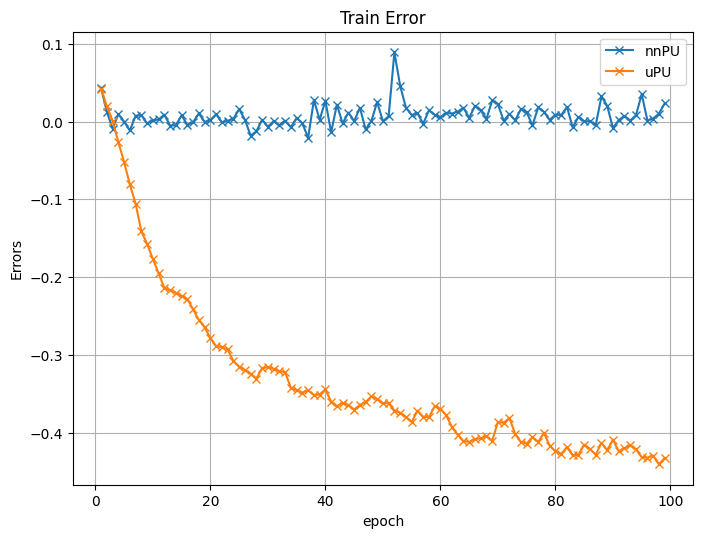

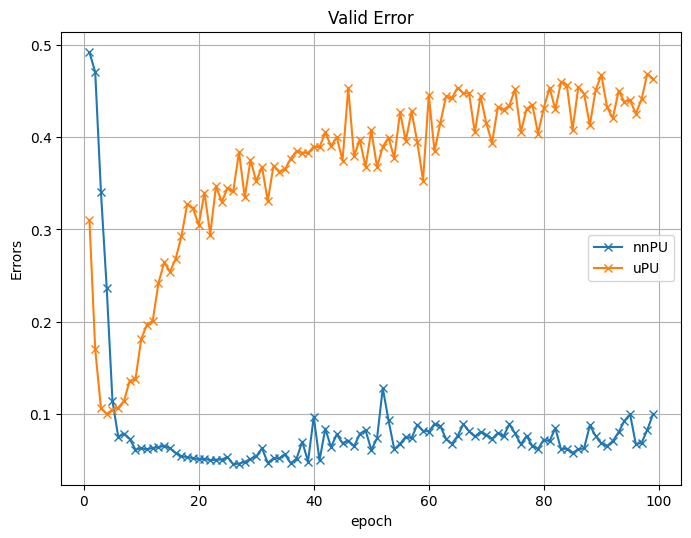

In [ ]:
plot_error_chainer(nnpu_upu_dict)
# del trainer_nnPU, trainer_uPU

>## 10 samplings Prior experiment

In [ ]:
#prior =  dataset['train'].get_prior()

# n_epochs   = 100
# kwargs2 = {
#           'train_Dataloader': dataloader['train'],
#           'valid_Dataloader': dataloader['valid'],
#           'validtrain_Dataloader': dataloader['validtrain'],
#           'epochs': n_epochs,           
#           }
# print(kwargs2)

In [ ]:
nb_seeds = 10

results_prior_samplings = {
    '0.8': None,
    '0.9': None,
    '1.0': None,
    '1.1': None,
    '1.2': None,
}


def Sampling_Training(results_prior_samplings: dict, nb_seeds=10):
  batch_iter = tqdm(results_prior_samplings.items(), 'Prior ', total=len(results_prior_samplings.items()),
                          leave= False)

  for key, array_save in batch_iter:
    mean_prior = []
    batch_iter.set_description('Prior {}'.format(key))  
    
    progressbar = trange(nb_seeds, desc='Seed', leave= False)
    
    for SEED in progressbar:
      # Intialisation
      np.random.seed(SEED)
      torch.manual_seed(SEED)
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
      
      # Dataset
      XYtrain, XYtest, prior = load_dataset("mnist", 1000, 60000)
      prior = torch.tensor(prior)
      ##Chainer
      dataset = {'train': MNIST_Chainer(XYtrain, transform= None),
                'valid': MNIST_Chainer(XYtest, transform= None)}       

      ##PyTorch 
      # dataset = {'train': PU_MNIST(root='/content/', train= True, download= download,transform= transforms),
      #            'valid' : PN_MNIST(root='/content/', train= False, download= download,transform= transforms)}        
      batch_size =   30000
      dataloader = {'train': DataLoader(dataset['train'], batch_size= batch_size, shuffle= True, drop_last=True, **kwargs),   # drop_last= True,
                    'validtrain': DataLoader(dataset['train'], batch_size= batch_size, shuffle= False, **kwargs),
                    'valid': DataLoader(dataset['valid'], batch_size= batch_size, shuffle= False, **kwargs)}

      n_epochs   = 100
      kwargs2 = {
          'train_Dataloader': dataloader['train'],
          'valid_Dataloader': dataloader['valid'],
          'validtrain_Dataloader': dataloader['validtrain'],
          'epochs': n_epochs,   
            }

      
      # Model
      model = MLP().to(device)
      lr = 0.001 #0.001 is the original
      optimizer = torch.optim.Adam(model.parameters(), lr= lr, weight_decay=0.005)

      # Trainer setup
      modifier = float(key)
      trainer = Trainer('nnPU',
                        model,
                        device, 
                        PULoss(prior= prior*modifier),
                        prior,
                        optimizer,
                        lr_scheduler = None,
                        **kwargs2)  
      
      # Run training
      trainer.run_trainer()

      # Retrieve results

      mean_prior.append(trainer.valid_error)
      # print(mean_prior)

      # Since it is saved, clear everything 
      trainer.train_loss.clear()
      trainer.valid_loss.clear()

      trainer.train_error.clear()
      # trainer.valid_error.clear()

      trainer.train_ROC_AUC.clear()
      trainer.valid_ROC_AUC.clear()

      trainer.learning_rate.clear()


      trainer.test1.clear() 
      trainer.test2.clear()
      # print(mean_prior)

      # Delete to save RAM (maybe overkill)
      del XYtrain, XYtest, dataset, dataloader
    
    # Save Mean Results for each SEED
    results_prior_samplings[key]= [np.mean(k, dtype= np.float32) for k in zip(*mean_prior)]
    # print(results_prior_samplings[key])
    #del mean_prior
    progressbar.close()

    # # Delete to save RAM 
    # del trainer, modifier, optimizer, kwargs2, n_epochs, dataloader, dataset, kwargs
    

In [ ]:
Sampling_Training(results_prior_samplings)
clear_output()

>>### Results

In [ ]:
def plot_prior_experiment(trainer_dict,to_save= False):
  plt.figure(figsize=(8, 6), dpi=100)
  plt.xlabel('epoch')
  plt.ylabel('Errors')
  plt.title('Modified Prior Valid on 10 samplings')
  plt.grid()

  for key, trainer in trainer_dict.items():
    if key == '1.0':
      plt.plot(np.arange(len(trainer))[1:], trainer[1:], '--', marker= "x")
    else:
      plt.plot(np.arange(len(trainer))[1:], trainer[1:], marker= "x")
  plt.legend(trainer_dict.keys())

  if to_save:
      name = 'modified_prior_train_10_sampling'
      name = name + '.png'
      path = '/content/drive/MyDrive/Colab Notebooks/MasterThesis/MLP/img'
      path = os.path.join(path, name)
      print(path)
      plt.savefig(path)

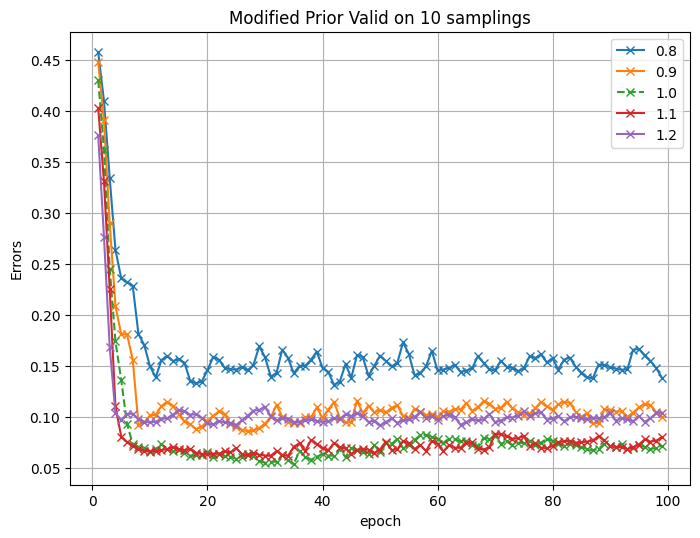

In [ ]:
plot_prior_experiment(results_prior_samplings)